# Regression Feature Engineering Notebook (Financial Impact Prediction)
# Feature Engineering Summary for Financial Impact Regression

This notebook focuses on creating meaningful features to predict the financial impact (in USD) of car shipment delays. The key steps include:

- **Temporal Features:** Extracted month and quarter from the scheduled assembly date to capture seasonal and quarterly trends affecting shipment delays.

- **Delay Flags:** Created binary flags indicating whether critical car parts (engine, transmission, brake system, suspension, infotainment) arrived late based on a 2-day cutoff rule before assembly.

- **Aggregated Delay Metrics:** Computed total delayed parts, count of critical delayed parts, and their ratios to quantify overall delay severity and criticality.

- **Interaction Features:** Engineered combined features reflecting urgency, supplier reliability gaps, and environmental factors (holidays, strikes, weather) interacting with delays.

- **Leakage Control:** Dropped columns that either leak target information (e.g., delay days, car delayed flags) or are irrelevant to model training to ensure robust prediction.

- **Target Transformation:** Applied log transformation on the financial impact target variable to reduce skewness and improve model stability.

# Goal: Prepare dataset with relevant features to predict financial impact of car shipment delays

In [33]:
# Step 1: Import Required Libraries
# We are using pandas for data manipulation and NumPy for numerical operations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Step 2: Load Cleaned Dataset
df = pd.read_csv("Cleaned_car_automated_dataset.csv")
df.head()

,Car_ID,Scheduled_Assembly_Date,Engine_Delivery_Date,Engine_Supplier_Region,Engine_Supplier_Reliability,Engine_Transport_Mode,Is_Critical_Engine,Transmission_Delivery_Date,Transmission_Supplier_Region,Transmission_Supplier_Reliability,...,Transmission_Supplier_Group,Brake_System_Supplier_Group,Suspension_Supplier_Group,Infotainment_Supplier_Group,Engine_Reliability_Score,Transmission_Reliability_Score,Brake_System_Reliability_Score,Suspension_Reliability_Score,Infotainment_Reliability_Score,Traffic_Severity_Index
0,CAR_942,2023-01-31,2023-01-24,EAST,0.76,ROAD,1,2023-01-30,NORTH,0.79,...,NORTH_ROAD,SOUTH_SEA,EAST_SEA,NORTH_ROAD,0.302632,0.329114,0.282609,0.239130,0.310345,1.0
1,CAR_546,2023-01-31,2023-01-22,NORTH,0.75,SEA,1,2023-01-24,EAST,0.98,...,EAST_AIR,EAST_SEA,NORTH_AIR,WEST_SEA,0.289474,0.328571,0.230769,0.311688,0.400000,1.0
2,CAR_465,2023-01-31,2023-01-29,WEST,0.74,AIR,0,2023-01-28,EAST,0.95,...,EAST_AIR,EAST_AIR,WEST_ROAD,EAST_AIR,0.346154,0.328571,0.383562,0.356322,0.298851,1.0
3,CAR_807,2023-01-31,2023-02-05,EAST,0.85,ROAD,0,2023-02-03,EAST,0.92,...,EAST_ROAD,NORTH_SEA,WEST_AIR,NORTH_ROAD,0.302632,0.279070,0.273810,0.321839,0.310345,1.5
4,CAR_286,2023-01-31,2023-01-28,SOUTH,0.79,AIR,0,2023-01-31,SOUTH,0.79,...,SOUTH_SEA,NORTH_AIR,SOUTH_ROAD,WEST_SEA,0.270270,0.300000,0.260274,0.224490,0.400000,1.0


In [35]:
df.shape # Expecting around 1007 records and 49 columns

(1010, 65)

In [36]:
# View Available Columns
# This gives us a view of all part-level, supplier-level, and shipment-level features available for engineering.
df.columns # Check all feature names and understand available variables

Index(['Car_ID', 'Scheduled_Assembly_Date', 'Engine_Delivery_Date',
       'Engine_Supplier_Region', 'Engine_Supplier_Reliability',
       'Engine_Transport_Mode', 'Is_Critical_Engine',
       'Transmission_Delivery_Date', 'Transmission_Supplier_Region',
       'Transmission_Supplier_Reliability', 'Transmission_Transport_Mode',
       'Is_Critical_Transmission', 'Brake_System_Delivery_Date',
       'Brake_System_Supplier_Region', 'Brake_System_Supplier_Reliability',
       'Brake_System_Transport_Mode', 'Is_Critical_Brake_System',
       'Suspension_Delivery_Date', 'Suspension_Supplier_Region',
       'Suspension_Supplier_Reliability', 'Suspension_Transport_Mode',
       'Is_Critical_Suspension', 'Infotainment_Delivery_Date',
       'Infotainment_Supplier_Region', 'Infotainment_Supplier_Reliability',
       'Infotainment_Transport_Mode', 'Is_Critical_Infotainment',
       'Car_Delayed', 'Delay_Days', 'Financial_Impact_USD',
       'Engine_Delayed_Flag', 'Transmission_Delayed_Flag',
   

In [37]:
# Step 3: Convert Assembly Date to Datetime and Extract Temporal Features
df["Scheduled_Assembly_Date"]= pd.to_datetime(df["Scheduled_Assembly_Date"])

In [38]:
# Extracting month and quarter of scheduled shipment for seasonal patterns
df['Month_Scheduled'] = df['Scheduled_Assembly_Date'].dt.month
df['Quarter_Scheduled'] = df['Scheduled_Assembly_Date'].dt.quarter

The exact Scheduled Assembly Date provides highly granular information that can be noisy and less effective for modeling temporal patterns. To capture meaningful seasonality and trends in shipment delays, we extract:

- Month of Scheduled Shipment (Month_Scheduled)

- Quarter of Scheduled Shipment (Quarter_Scheduled)

These aggregated time features enable the detection of seasonal fluctuations and cyclical patterns impacting supply chain performance, such as:

- Increased delays during peak production quarters

- Variations due to holidays, weather conditions, or supplier capacity cycles

Incorporating these temporal features improves the model’s ability to generalize over time and anticipate periods with elevated delay risk.

In [39]:
# Step 4: Convert Parts Delivery Dates to Datetime Format
parts_delivery_cols=["Engine_Delivery_Date", "Transmission_Delivery_Date", "Brake_System_Delivery_Date", "Suspension_Delivery_Date", "Infotainment_Delivery_Date"]
for col in parts_delivery_cols:
  df[col]=pd.to_datetime(df[col])
# Step 5: Generate Delayed Flags for Each Part Based on 2-Day Cutoff Rule
parts_flag_cols=['Engine_Delayed_Flag', 'Transmission_Delayed_Flag','Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag', 'Infotainment_Delayed_Flag']
# If part arrives after the cutoff (2 days before assembly), it's delayed
prediction_cutoff_date = df["Scheduled_Assembly_Date"] - pd.Timedelta(days=2)
for delivery_col, flag_col in zip(parts_delivery_cols, parts_flag_cols,):
  df[flag_col]= ((df[delivery_col].notna()) & (df[delivery_col]>prediction_cutoff_date)).astype(int)

In the automotive supply chain, each vehicle assembly requires critical parts to arrive at least 2 days in advance of the scheduled assembly date. This 2-day buffer accounts for:

- Quality checks, paperwork, and pre-assembly processing of parts

Internal logistics like sorting, staging, and line preparation

To operationalize this:

- We converted all parts delivery dates into a uniform datetime format to enable accurate comparisons.

- We created delay flags for each part type, checking whether a part arrived later than 2 days before the scheduled car assembly date.

- If a part missed this 2-day window, it was marked as delayed (flag = 1).

- If it arrived on time, it was marked as not delayed (flag = 0).

This approach ensures our models predict shipment delays based on real-world logistics timelines and business constraints.

In [40]:
# Step 6: Create Total Parts Delayed Feature
df["Total_Parts_Delayed"]=df[['Engine_Delayed_Flag', 'Transmission_Delayed_Flag','Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag', 'Infotainment_Delayed_Flag']].sum(axis=1)

To quantify the overall impact of parts delays on car shipment, we calculate the Total Parts Delayed by summing the individual delay flags across all critical parts:
- Engine
- Transmission
- Brake System
- Suspension
- Infotainment

This aggregated metric provides a clear indicator of how many parts experienced delivery delays per vehicle, helping identify shipments at higher risk due to multiple delayed components. It supports prioritizing interventions on orders with greater cumulative delays.

In [41]:
# Step 7: Create Flags for Critical Part Delays
# This checks if any delayed part was critical to the car
df["Any_Critical_Part_Delayed"]=((df["Engine_Delayed_Flag"]& df["Is_Critical_Engine"])|
(df["Transmission_Delayed_Flag"]& df["Is_Critical_Transmission"])|
(df["Brake_System_Delayed_Flag"]& df["Is_Critical_Brake_System"])|
(df["Suspension_Delayed_Flag"] & df["Is_Critical_Suspension"])|
(df["Infotainment_Delayed_Flag"] & df["Is_Critical_Infotainment"]))

This feature identifies whether any delayed part is critical to the vehicle’s assembly process.

By combining the delay status of each part with its criticality indicator, we flag shipments where at least one essential component was delayed.

This binary flag helps prioritize delays that are more likely to cause major production disruptions, as critical parts have a direct impact on the car’s completion and shipment schedule

In [42]:
# Step 8: Count of Critical Parts Delayed
df['Sum_Critical_Parts_Delayed'] = (
    (df["Engine_Delayed_Flag"] & df["Is_Critical_Engine"]) +
    (df["Transmission_Delayed_Flag"] & df["Is_Critical_Transmission"]) +
    (df["Brake_System_Delayed_Flag"] & df["Is_Critical_Brake_System"]) +
    (df["Suspension_Delayed_Flag"] & df["Is_Critical_Suspension"]) +
    (df["Infotainment_Delayed_Flag"] & df["Is_Critical_Infotainment"])
)

This feature calculates the total number of critical parts that experienced delivery delays for each car shipment.

By summing the flags where a part is both delayed and marked as critical, it provides a numeric measure of how many essential components were late.

This count enables a more granular assessment of delay severity and supports prioritization of shipments with multiple critical part delays, which typically have higher risk of overall shipment delay.

In [43]:
df["Total_Critical_Parts"] = df[[
    "Is_Critical_Engine", "Is_Critical_Transmission",
    "Is_Critical_Brake_System", "Is_Critical_Suspension",
    "Is_Critical_Infotainment"
]].sum(axis=1)


In [44]:
df["Non_Critical_Parts_Delayed_Count"] = df["Total_Parts_Delayed"] - df["Sum_Critical_Parts_Delayed"]

# Step 9: Engineering Ratio-Based Features


In [45]:
df["Critical_Parts_Ratio"] = df["Sum_Critical_Parts_Delayed"] / df["Total_Critical_Parts"]
df["Critical_Parts_Ratio"] = df["Critical_Parts_Ratio"].fillna(0)

In [46]:
# Example mapping for ordinal urgency levels
urgency_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}

df['Order_Urgency_Num'] = df['Order_Urgency'].map(urgency_mapping)

# Now you can use 'Order_Urgency_Num' for calculations, e.g.:
df['Delay_Per_Urgency'] = df['Total_Parts_Delayed'] / df['Order_Urgency_Num'].replace(0, np.nan)


In [47]:
df['Non_Critical_Parts_Delayed_Ratio'] = df['Non_Critical_Parts_Delayed_Count'] / (5 - df['Total_Critical_Parts']).replace(0, np.nan)
df['Non_Critical_Parts_Delayed_Ratio'] = df['Non_Critical_Parts_Delayed_Ratio'].fillna(0)

In [48]:
df["Total_Delayed_Ratio"] = df["Total_Parts_Delayed"] / 5
#(max 5 parts)

In [49]:
df['Reliability_Gap_Engine_Trans'] = df['Engine_Reliability_Score'] - df['Transmission_Reliability_Score']
df['Reliability_Gap_Brake_Susp'] = df['Brake_System_Reliability_Score'] - df['Suspension_Reliability_Score']

# Step 10: Binary Summary Flags

In [50]:
df['Eng_Reliability_x_Delay'] = df['Engine_Reliability_Score'] * df['Engine_Delayed_Flag']
df['Trans_Reliability_x_Delay'] = df['Transmission_Reliability_Score'] * df['Transmission_Delayed_Flag']
df['Brake_Reliability_x_Delay'] = df['Brake_System_Reliability_Score'] * df['Brake_System_Delayed_Flag']
df['Susp_Reliability_x_Delay'] = df['Suspension_Reliability_Score'] * df['Suspension_Delayed_Flag']
df['Info_Reliability_x_Delay'] = df['Infotainment_Reliability_Score'] * df['Infotainment_Delayed_Flag']

df['Critical_Engine_x_Delay'] = df['Is_Critical_Engine'] * df['Engine_Delayed_Flag']
df['Critical_Trans_x_Delay'] = df['Is_Critical_Transmission'] * df['Transmission_Delayed_Flag']
df['Critical_Brake_x_Delay'] = df['Is_Critical_Brake_System'] * df['Brake_System_Delayed_Flag']
df['Critical_Susp_x_Delay'] = df['Is_Critical_Suspension'] * df['Suspension_Delayed_Flag']
df['Critical_Info_x_Delay'] = df['Is_Critical_Infotainment'] * df['Infotainment_Delayed_Flag']


df['Urgency_x_TotalDelayed'] = df['Order_Urgency'] * df['Total_Parts_Delayed']
df['Holiday_x_CriticalDelay'] = df['Holiday_Proximity'] * df['Any_Critical_Part_Delayed']
df['Strike_x_TotalDelayed'] = df['Strike_Notice'] * df['Total_Parts_Delayed']
df['Weather_x_TotalDelayed'] = df['Weather_Condition_On_Delivery'] * df['Total_Parts_Delayed']


In [51]:
df['Is_Any_Part_Delayed'] = (df['Total_Parts_Delayed'] > 0).astype(int)

In [52]:
df['All_Parts_On_Time'] = (df['Total_Parts_Delayed'] == 0).astype(int)

In [53]:
df['All_Critical_Parts_On_Time'] = (df['Sum_Critical_Parts_Delayed'] == 0).astype(int)

In [54]:
df.columns

Index(['Car_ID', 'Scheduled_Assembly_Date', 'Engine_Delivery_Date',
       'Engine_Supplier_Region', 'Engine_Supplier_Reliability',
       'Engine_Transport_Mode', 'Is_Critical_Engine',
       'Transmission_Delivery_Date', 'Transmission_Supplier_Region',
       'Transmission_Supplier_Reliability', 'Transmission_Transport_Mode',
       'Is_Critical_Transmission', 'Brake_System_Delivery_Date',
       'Brake_System_Supplier_Region', 'Brake_System_Supplier_Reliability',
       'Brake_System_Transport_Mode', 'Is_Critical_Brake_System',
       'Suspension_Delivery_Date', 'Suspension_Supplier_Region',
       'Suspension_Supplier_Reliability', 'Suspension_Transport_Mode',
       'Is_Critical_Suspension', 'Infotainment_Delivery_Date',
       'Infotainment_Supplier_Region', 'Infotainment_Supplier_Reliability',
       'Infotainment_Transport_Mode', 'Is_Critical_Infotainment',
       'Car_Delayed', 'Delay_Days', 'Financial_Impact_USD',
       'Engine_Delayed_Flag', 'Transmission_Delayed_Flag',
   

# Step 11: Drop Leakage or Unnecessary Columns


In [55]:
# Drop Irrelevant or Leakage-Prone Columns
columns_to_drop = [
    'Car_ID',  # only needed for reference
    'Scheduled_Assembly_Date',
    'Engine_Delivery_Date', 'Transmission_Delivery_Date',
    'Brake_System_Delivery_Date', 'Suspension_Delivery_Date',
    'Infotainment_Delivery_Date',
    'Engine_Delay_Reason', 'Transmission_Delay_Reason',
    'Brake_System_Delay_Reason', 'Suspension_Delay_Reason',
    'Infotainment_Delay_Reason',
    'Inventory_Buffer_Used', #Not useful for prediction
    'Delay_Days', 'Valid_Delay', 'Car_Delayed' # Leakage into label
    ]
df = df.drop(columns=columns_to_drop)

# Step 12: Final Feature Set Preview

In [56]:
df.columns

Index(['Engine_Supplier_Region', 'Engine_Supplier_Reliability',
       'Engine_Transport_Mode', 'Is_Critical_Engine',
       'Transmission_Supplier_Region', 'Transmission_Supplier_Reliability',
       'Transmission_Transport_Mode', 'Is_Critical_Transmission',
       'Brake_System_Supplier_Region', 'Brake_System_Supplier_Reliability',
       'Brake_System_Transport_Mode', 'Is_Critical_Brake_System',
       'Suspension_Supplier_Region', 'Suspension_Supplier_Reliability',
       'Suspension_Transport_Mode', 'Is_Critical_Suspension',
       'Infotainment_Supplier_Region', 'Infotainment_Supplier_Reliability',
       'Infotainment_Transport_Mode', 'Is_Critical_Infotainment',
       'Financial_Impact_USD', 'Engine_Delayed_Flag',
       'Transmission_Delayed_Flag', 'Brake_System_Delayed_Flag',
       'Suspension_Delayed_Flag', 'Infotainment_Delayed_Flag',
       'Any_Critical_Part_Delayed', 'Order_Urgency', 'Holiday_Proximity',
       'Weather_Condition_On_Delivery', 'Strike_Notice', 'Producti

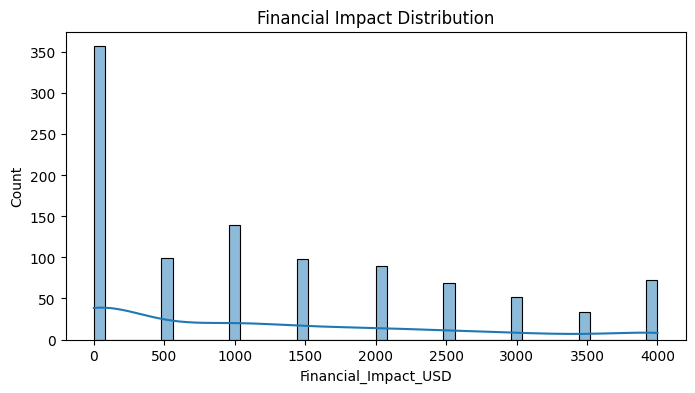

count    1010.000000
mean     1236.138614
std      1281.657956
min         0.000000
25%         0.000000
50%      1000.000000
75%      2000.000000
max      4000.000000
Name: Financial_Impact_USD, dtype: float64


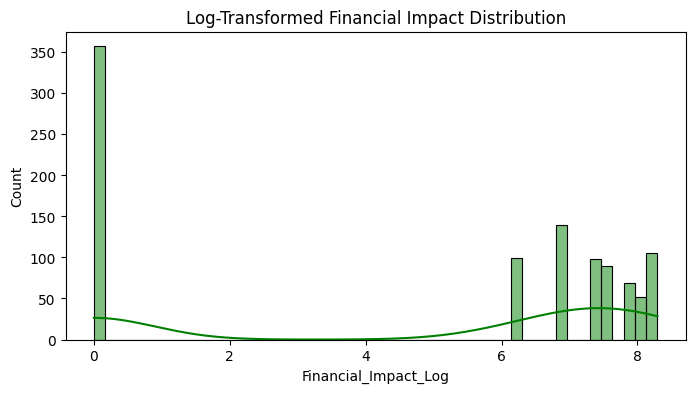

In [57]:
# Visualize Financial Impact distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Financial_Impact_USD'], bins=50, kde=True)
plt.title('Financial Impact Distribution')
plt.show()

# Summary stats for outliers check
print(df['Financial_Impact_USD'].describe())

# strongly right-skewed, apply log transform (add 1 to avoid log(0))
df['Financial_Impact_Log'] = np.log1p(df['Financial_Impact_USD'])

# Visualize transformed target
plt.figure(figsize=(8,4))
sns.histplot(df['Financial_Impact_Log'], bins=50, kde=True, color='green')
plt.title('Log-Transformed Financial Impact Distribution')
plt.show()


- Financial Impact USD shows a right-skewed distribution with many shipments incurring low or zero impact and some experiencing high penalties.

To improve modeling stability, a log transformation (log1p) was applied to the financial impact, reducing skewness and normalizing variance

# Engineered Features Summary

| Feature Name                   | Type      | Description / Engineering Logic                                                   | Purpose / Usefulness                                              |
|-------------------------------|-----------|----------------------------------------------------------------------------------|------------------------------------------------------------------|
| `Month_Scheduled`             | Numeric   | Extracted month from scheduled assembly date                                    | Capture seasonal shipment patterns                               |
| `Quarter_Scheduled`           | Numeric   | Extracted quarter from scheduled assembly date                                  | Capture quarterly trends                                         |
| `Engine_Delayed_Flag`         | Binary    | 1 if engine delivery date > (assembly date - 2 days), else 0                    | Flag delayed engine part                                         |
| `Transmission_Delayed_Flag`   | Binary    | Same logic for transmission                                                      | Flag delayed transmission part                                  |
| `Brake_System_Delayed_Flag`   | Binary    | Same for brake system                                                           | Flag delayed brake system part                                  |
| `Suspension_Delayed_Flag`     | Binary    | Same for suspension                                                             | Flag delayed suspension part                                    |
| `Infotainment_Delayed_Flag`   | Binary    | Same for infotainment                                                           | Flag delayed infotainment part                                  |
| `Total_Parts_Delayed`         | Numeric   | Sum of all individual delayed part flags                                       | Overall delay severity indicator                                |
| `Any_Critical_Part_Delayed`   | Binary    | 1 if any delayed part is critical, else 0                                      | Highlight critical delays that impact assembly                  |
| `Sum_Critical_Parts_Delayed`  | Numeric   | Count of critical parts delayed                                                 | Measure critical delay magnitude                                |
| `Total_Critical_Parts`        | Numeric   | Total number of critical parts                                                  | Baseline for ratios                                            |
| `Non_Critical_Parts_Delayed_Count` | Numeric | Total delayed parts minus critical delayed parts                              | Delay count of non-critical parts                               |
| `Critical_Parts_Ratio`        | Float     | Ratio of critical parts delayed to total critical parts                         | Normalized critical delay indicator                             |
| `Order_Urgency_Num`           | Numeric   | Numeric mapping of urgency levels (Low=1, Medium=2, High=3)                     | Quantify urgency for model                                     |
| `Delay_Per_Urgency`           | Float     | Total parts delayed divided by order urgency numeric                            | Interaction feature: delay severity adjusted by urgency       |
| `Non_Critical_Parts_Delayed_Ratio` | Float | Non-critical delayed parts / total non-critical parts                           | Non-critical delay intensity                                    |
| `Total_Delayed_Ratio`         | Float     | Total parts delayed divided by max parts (5)                                   | Proportion of parts delayed                                     |
| `Reliability_Gap_Engine_Trans`| Float     | Difference between engine and transmission reliability scores                   | Supplier reliability differences                               |
| `Reliability_Gap_Brake_Susp`  | Float     | Difference between brake system and suspension reliability                      | Supplier reliability differences                               |
| `Eng_Reliability_x_Delay`     | Float     | Engine reliability score * engine delayed flag                                 | Interaction of reliability & delay                             |
| `Trans_Reliability_x_Delay`   | Float     | Transmission reliability score * transmission delayed flag                     | Interaction of reliability & delay                             |
| `Brake_Reliability_x_Delay`   | Float     | Brake system reliability score * brake delayed flag                            | Interaction of reliability & delay                             |
| `Susp_Reliability_x_Delay`    | Float     | Suspension reliability score * suspension delayed flag                         | Interaction of reliability & delay                             |
| `Info_Reliability_x_Delay`    | Float     | Infotainment reliability score * infotainment delayed flag                     | Interaction of reliability & delay                             |
| `Critical_Engine_x_Delay`     | Binary    | Critical engine flag * engine delayed flag                                     | Interaction of criticality & delay                             |
| `Critical_Trans_x_Delay`      | Binary    | Critical transmission flag * transmission delayed flag                         | Interaction of criticality & delay                             |
| `Critical_Brake_x_Delay`      | Binary    | Critical brake flag * brake delayed flag                                       | Interaction of criticality & delay                             |
| `Critical_Susp_x_Delay`       | Binary    | Critical suspension flag * suspension delayed flag                             | Interaction of criticality & delay                             |
| `Critical_Info_x_Delay`       | Binary    | Critical infotainment flag * infotainment delayed flag                         | Interaction of criticality & delay                             |
| `Urgency_x_TotalDelayed`      | Numeric   | Order urgency * total parts delayed                                            | Combined urgency & delay severity                              |
| `Holiday_x_CriticalDelay`     | Numeric   | Holiday proximity flag * any critical part delayed                             | Impact of holidays on critical delays                         |
| `Strike_x_TotalDelayed`       | Numeric   | Strike notice flag * total parts delayed                                      | Impact of strikes on delays                                   |
| `Weather_x_TotalDelayed`      | Numeric   | Weather condition on delivery * total parts delayed                           | Weather impact on delays                                     |
| `Is_Any_Part_Delayed`         | Binary    | 1 if any part delayed, else 0                                                  | General delay indicator                                        |
| `All_Parts_On_Time`           | Binary    | 1 if no parts delayed, else 0                                                  | Opposite of delay indicator                                   |
| `All_Critical_Parts_On_Time`  | Binary    | 1 if no critical parts delayed, else 0                                         | Critical parts delay indicator                                |


# Step 13: Saving the dataset for modeling

In [58]:
df.to_csv("Financial_Impact_Regression_Final_Dataset.csv", index=False)